# Parts Manufacturing - Quality Analysis

**Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cbook import boxplot_stats
from scipy.stats import binom
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

**Loading the dataset**

In [2]:
df = pd.read_csv('../input/parts-manufacturing-industry-dataset/Piece_Dimension.csv')

In [3]:
df.head()

,Item_No,Length,Width,Height,Operator
0,1,102.67,49.53,19.69,Op-1
1,2,102.50,51.42,19.63,Op-1
2,3,95.37,52.25,21.51,Op-1
3,4,94.77,49.24,18.60,Op-1
4,5,104.26,47.90,19.46,Op-1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Item_No   500 non-null    int64  
 1   Length    500 non-null    float64
 2   Width     500 non-null    float64
 3   Height    500 non-null    float64
 4   Operator  500 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 19.7+ KB


In [5]:
df.describe()

,Item_No,Length,Width,Height
count,500.000000,500.000000,500.00000,500.000000
mean,250.500000,99.769140,49.93288,20.293220
std,144.481833,4.107471,2.11382,1.051718
min,1.000000,87.520000,42.74000,17.370000
25%,125.750000,96.835000,48.34000,19.475000
50%,250.500000,99.565000,49.82500,20.310000
75%,375.250000,102.035000,51.46250,21.142500
max,500.000000,116.600000,58.26000,23.390000


* We have 5 features: Item_No, Length, Width, Height and Operator.
* As we don't need the Item_No, let's drop it.
* Here we also might analyze the volume of each part.

## Initial Analysis

**Dropping Item_No column**

In [6]:
df = df.drop('Item_No', axis=1)

**Analyzing Volume - Packaging**

In [7]:
df['Volume'] = round((df['Length'] *  df['Width'] *  df['Height']), 2)

In [8]:
max_volume = df['Volume'].max()
min_volume = df['Volume'].min()

print('We should consider a package with the volume of ' + str(max_volume))
print('We should also consider an internal filling of the package with the volume of ' + str(max_volume - min_volume))

We should consider a package with the volume of 146754.61
We should also consider an internal filling of the package with the volume of 71750.93


* We should consider a package with the volume of 146754.61
* We should also consider an internal filling of the package with the volume of 71750.93

## Exploratory Data Analysis

As we don't need "Volume" anymore since the information is implicit in the other variables, let's drop it.

In [9]:
df = df.drop('Volume', axis=1)

<AxesSubplot:xlabel='Operator', ylabel='count'>

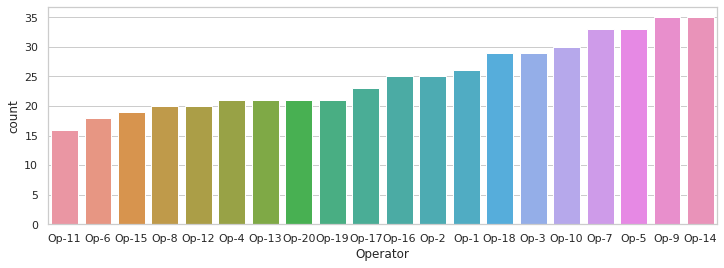

In [10]:
plt.figure(figsize=(12,4))
sns.set_theme(style="whitegrid")
#sns.countplot(data=df, x='Operator', order=df['Operator'].value_counts().index) Asceding order
sns.countplot(data=df, x='Operator', order=df['Operator'].value_counts().index[::-1])

So we have the number of parts each operator made in the period.

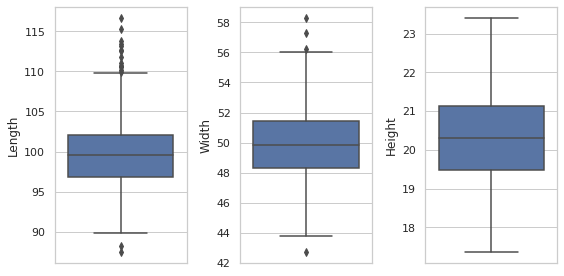

In [11]:
#dfLength = df['Length'].values
#dfWidth = df['Width'].values
#dfHeight = df['Height'].values
#sns.boxplot(data=dfLength, orient='v', ax=axes[0])
#sns.boxplot(data=dfWidth, orient='v', ax=axes[1])
#sns.boxplot(data=dfHeight, orient='v', ax=axes[2])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4))

sns.boxplot(data=df, y=df['Length'], ax=axes[0])
sns.boxplot(data=df, y=df['Width'], ax=axes[1])
sns.boxplot(data=df, y=df['Height'], ax=axes[2])

fig.tight_layout()

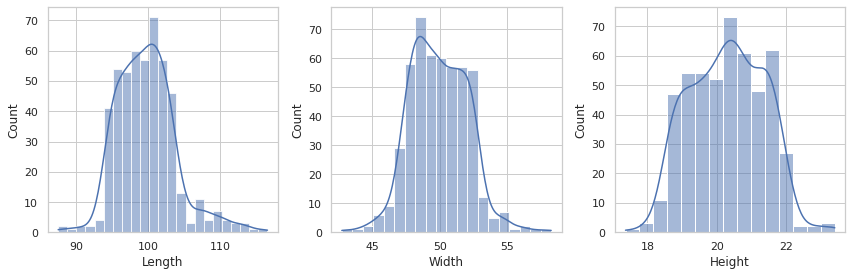

In [12]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

sns.histplot(data=df, x=df['Length'], kde=True, ax=axes[0])
sns.histplot(data=df, x=df['Width'], kde=True, ax=axes[1])
sns.histplot(data=df, x=df['Height'], kde=True, ax=axes[2])

fig.tight_layout()

So let's consider that outliers from the boxplot are 'Defective'

The lower whisker is at the lowest datum above Q1 - whis x (Q3-Q1), and the upper whisker at the highest datum below Q3 + whis x (Q3-Q1), where Q1 and Q3 are the first and third quartiles. The default value of whis = 1.5 corresponds to Tukey's original definition of boxplots.

In [13]:
feat = ['Length','Width','Height']

In [14]:
#feat = ['Length','Width','Height']
for col in feat:
    print(col)
    print(pd.Series(boxplot_stats(df[col])[0]))
    print('\n')

Length
mean                                               99.76914
iqr                                                     5.2
cilo                                              99.199895
cihi                                              99.930105
whishi                                               109.79
whislo                                                89.82
fliers    [87.52, 88.28, 110.54, 110.18, 110.72, 112.69,...
q1                                                   96.835
med                                                  99.565
q3                                                  102.035
dtype: object


Width
mean                          49.93288
iqr                             3.1225
cilo                         49.605761
cihi                         50.044239
whishi                           56.04
whislo                            43.8
fliers    [42.74, 57.26, 58.26, 56.26]
q1                               48.34
med                             49.825
q3                  

In [15]:
#feat = ['Length','Width','Height']

def get_status(row):
    # when applying the function get_status(), it is called each row at a time
    # row is a pd.Series
    #print('row: ', row, '\n') <- try if you want to see what gets passed to the function
    for col in feat:
        # in each row you have to check 3 values (3 columns)
        # if this if condition is True only once, the function returns 'Defective'
        if (
            (row[col] > boxplot_stats(df[col])[0]['whishi']) 
            or 
            (row[col] < boxplot_stats(df[col])[0]['whislo'])
        ):
            
            return 'Defective'
        
    # if it didn't return anything till here (-> 3x condition was False) it will return `Perfect
    return 'Perfect'

df['Status'] = df.apply(get_status,axis=1)

In [16]:
    # For instance, to return the Defective rows, you can use a single measure: 
#df[df['Length'] < boxplot_stats(df['Length'])[0]['whislo']]
    # Or any Defective rows:
df[df['Status']=='Defective']

,Length,Width,Height,Operator,Status
41,110.54,51.07,21.95,Op-2,Defective
56,110.18,51.89,21.36,Op-3,Defective
61,105.00,57.26,21.62,Op-3,Defective
63,110.72,52.54,21.06,Op-3,Defective
67,112.69,50.68,20.33,Op-3,Defective
68,111.83,53.31,20.12,Op-3,Defective
69,103.73,58.26,20.37,Op-3,Defective
71,109.87,52.23,20.94,Op-3,Defective
73,113.45,46.96,23.31,Op-3,Defective
85,104.22,42.74,19.05,Op-4,Defective


In [17]:
df['Status'].value_counts()

Perfect      480
Defective     20
Name: Status, dtype: int64

<AxesSubplot:xlabel='Status', ylabel='count'>

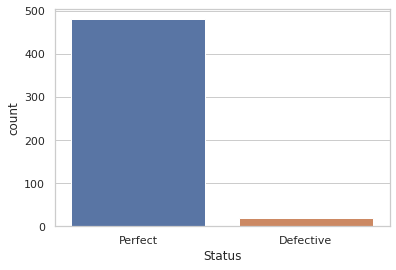

In [18]:
#plt.figure(figsize=(4,8))
#sns.set_theme(style="whitegrid")
sns.countplot(data=df, x='Status')

In [19]:
#(df['Status'] == 'Defective' / df['Status'] == 'Perfect'.sum()) * 100
defective = 100*df[df['Status'] == 'Defective']['Status'].count() / df['Status'].count()
perfect = 100*df[df['Status'] == 'Perfect']['Status'].count() / df['Status'].count()
print(f'Percentage Defective: {defective}%')

print(f'Percentage Perfect:  {perfect}%')

Percentage Defective: 4.0%
Percentage Perfect:  96.0%


Unbalanced problem

<AxesSubplot:xlabel='Status', ylabel='count'>

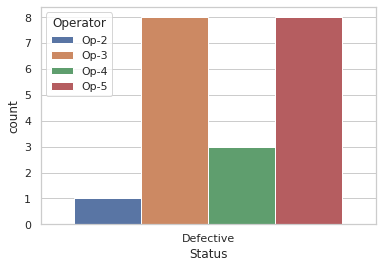

In [20]:
defective = df[df['Status'] == 'Defective']['Status']
hue_op = df[df['Status'] == 'Defective']['Operator']
sns.countplot(data=df, x=defective, hue=hue_op)

So now we conclude that the operators with the highest number of errors were Op-2, Op-3, Op-4 and Op-5

In [21]:
defective_op = df[df['Status'] == 'Defective']['Operator'].unique()
defective_parts = df[df['Status'] == 'Defective']['Operator'].value_counts()
defective_total = df['Operator'].value_counts()
defective_comparision = (defective_parts/defective_total)[defective_op]

<AxesSubplot:ylabel='Operator'>

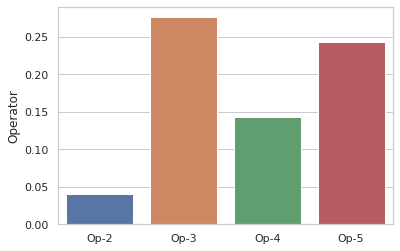

In [22]:
sns.barplot(x=defective_op, y=defective_comparision)

Op-5 is making 25% of its parts wrongly. Likewise, Op-3 is making more than 25% wrong.

We should consider training sessions for these operators.

<AxesSubplot:>

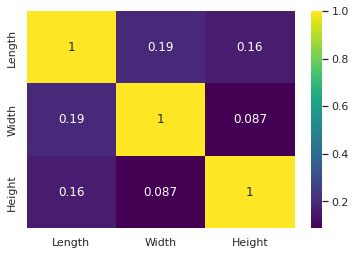

In [23]:
sns.heatmap(df.corr(), annot=True, cmap='viridis')

It seems there is no correlation between the measures

In [24]:
meanL = df['Length'].mean() #99.76914
meanW = df['Width'].mean() #49.932880000000004
meanH = df['Height'].mean() #20.29322

So it seems that the expected measures of a part is:
* **Length:** 100
* **Width:** 50
* **Height:** 20

Or a **ratio of 5/2/1**

**As we saw earlier, the manufacturer has 4% defects rate in production. Let's considere the buyer decides to test 20 random parts and will accept the supplier if there are 2 or less defectives. What is the probability of getting accepted?**

In [25]:
two_rejections = round(100 * binom.sf(2, 20, 0.04),2)
x_ax = np.arange(0, 21)
y_ax = binom.pmf(x_ax, 20, 0.04)
y_cumulative = binom.cdf(x_ax, 20, 0.04)

In [26]:
print(f'The percentage of rejections will be: {two_rejections}%')

The percentage of rejections will be: 4.39%


<AxesSubplot:>

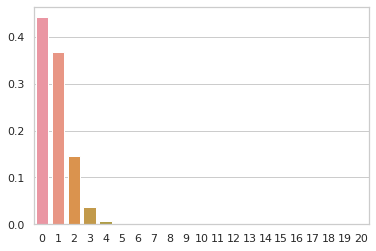

In [27]:
sns.barplot(x=x_ax, y=y_ax)
#Chances to have x defectives parts per sample.
#For instance, around 45% of chance to have 0 defective per sample. Around 35% of chance to have just 1 defective per sample. And so on.

<AxesSubplot:>

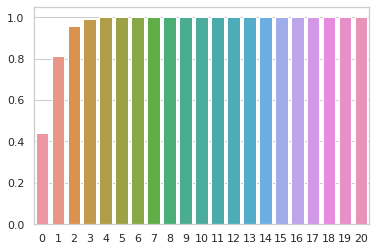

In [28]:
sns.barplot(x=x_ax, y=y_cumulative)
#Chances to have x defective parts or less per sample.
#For instance, around 80% of chance to have 1 defective part or less per sample. Around 95% of chance to have 2 defective parts or less per sample.

## Data PreProcessing

**Veryfing if we have missing data**

In [29]:
df.isnull().sum()

Length      0
Width       0
Height      0
Operator    0
Status      0
dtype: int64

**Veryfing if we have categorial data and converting them to dummy variables.**

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Length    500 non-null    float64
 1   Width     500 non-null    float64
 2   Height    500 non-null    float64
 3   Operator  500 non-null    object 
 4   Status    500 non-null    object 
dtypes: float64(3), object(2)
memory usage: 19.7+ KB


In [31]:
#We can drop the Operator column
df = df.drop('Operator', axis=1)

#And we should covert the Status column to dummy variables
categorical = ["Status"]

In [32]:
df_final = pd.get_dummies(df, columns=categorical, drop_first=True)

In [33]:
df_final

,Length,Width,Height,Status_Perfect
0,102.67,49.53,19.69,1
1,102.50,51.42,19.63,1
2,95.37,52.25,21.51,1
3,94.77,49.24,18.60,1
4,104.26,47.90,19.46,1
...,...,...,...,...
495,101.24,49.03,20.96,1
496,98.37,52.12,19.68,1
497,96.49,48.78,19.19,1
498,94.16,48.39,21.60,1


**Train Test Split**

In [34]:
X = df_final.drop('Status_Perfect', axis=1).values
y = df_final["Status_Perfect"].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=101)

**Normalizing the Data**

In [36]:
scaler = MinMaxScaler()

In [37]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Creating the Model**

In [38]:
X_train.shape

(250, 3)

In [39]:
model = Sequential()

model.add(Dense(12, activation="relu"))
model.add(Dropout(0.2)) #preventing overfitting

model.add(Dense(6, activation="relu")) #reducing number of neurons of a half
model.add(Dropout(0.2))

model.add(Dense(3, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation="sigmoid")) #because it's a binary classification

model.compile(loss="binary_crossentropy", optimizer="adam")

2022-07-14 14:03:46.496970: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [40]:
model.fit(x = X_train, y = y_train, epochs = 25, validation_data=(X_test, y_test))

2022-07-14 14:03:46.701906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
8/8 [==============================] - 1s 35ms/step - loss: 0.7522 - val_loss: 0.7356
Epoch 2/25
8/8 [==============================] - 0s 9ms/step - loss: 0.7306 - val_loss: 0.7117
Epoch 3/25
8/8 [==============================] - 0s 8ms/step - loss: 0.7084 - val_loss: 0.6956
Epoch 4/25
8/8 [==============================] - 0s 9ms/step - loss: 0.6944 - val_loss: 0.6848
Epoch 5/25
8/8 [==============================] - 0s 9ms/step - loss: 0.6843 - val_loss: 0.6779
Epoch 6/25
8/8 [==============================] - 0s 9ms/step - loss: 0.6774 - val_loss: 0.6729
Epoch 7/25
8/8 [==============================] - 0s 8ms/step - loss: 0.6742 - val_loss: 0.6687
Epoch 8/25
8/8 [==============================] - 0s 8ms/step - loss: 0.6695 - val_loss: 0.6648
Epoch 9/25
8/8 [==============================] - 0s 8ms/step - loss: 0.6648 - val_loss: 0.6612
Epoch 10/25
8/8 [==============================] - 0s 8ms/step - loss: 0.6621 - val_loss: 0.6576
Epoch 11/25
8/8 [=====================

## Evaluating Model Performance

In [41]:
model.history.history #dictionary of losses

{'loss': [0.7522139549255371,
  0.7305896878242493,
  0.7084228992462158,
  0.694375216960907,
  0.6842632293701172,
  0.6774479746818542,
  0.6741849780082703,
  0.6694771647453308,
  0.6647990942001343,
  0.6620831489562988,
  0.6581305265426636,
  0.6543987989425659,
  0.651176393032074,
  0.6476763486862183,
  0.6442337036132812,
  0.6414853930473328,
  0.6377533078193665,
  0.6348304152488708,
  0.6312584280967712,
  0.6283591985702515,
  0.6248125433921814,
  0.6219608783721924,
  0.6186041831970215,
  0.6156750321388245,
  0.612652063369751],
 'val_loss': [0.7355512976646423,
  0.7117015719413757,
  0.6955739259719849,
  0.6847931742668152,
  0.6779171824455261,
  0.6728697419166565,
  0.6686716079711914,
  0.6648170948028564,
  0.6612193584442139,
  0.6575942039489746,
  0.6540298461914062,
  0.6505703330039978,
  0.647128701210022,
  0.6436949372291565,
  0.6403126120567322,
  0.636946976184845,
  0.6335975527763367,
  0.6302674412727356,
  0.6269722580909729,
  0.623656451702

In [42]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

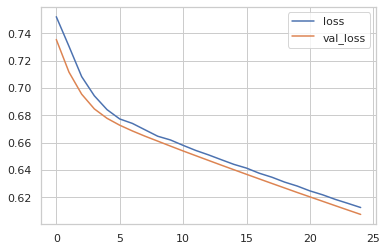

In [43]:
losses.plot()

**Creating predictions from the X_test set and displaying a classification report and confusion matrix for the X_test set.**

In [44]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

In [45]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.97      1.00      0.98       242

    accuracy                           0.97       250
   macro avg       0.48      0.50      0.49       250
weighted avg       0.94      0.97      0.95       250



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
print(confusion_matrix(y_test, predictions))

[[  0   8]
 [  0 242]]


* We had 97% of accuracy on our model. But the model didn't perform well because of the very unbalanced data and the small sample.
* We suffered with all the features (precision, recall and F1-score) for class 0 (zero) - defectives.